# Convolutional Neural Net and Galaxy Zoo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

In [2]:
# potentially new packages
import cv2
import imageio as iio

In [3]:
# load the classification data from galaxy zoo (shuffle the rows just to be safe)
df = pd.read_csv('data/training_solutions_rev1.csv')
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
def norm(x):
    return (x-x.max()) / (x.max() - x.min())

images_f = []
images   = []
classes  = []

# loop over galaxy IDs
for i,j in tqdm(enumerate(df['GalaxyID'].values)):
    
    # load image
    img_f = iio.v3.imread(f"data/images_training_rev1/{j}.jpg")
    
    # select green band and downsample to 80x80 (for speed)
    img = cv2.resize(img_f[:,:,0], (80, 80)) # 

    # select Spiral + Elliptical classification scores
    c1 = df['Class1.1'].values[i]
    c2 = df['Class1.2'].values[i]
    
    # only keep in sample if Spiral or Elliptical (e.g., not major merger or systematic)
    if (c1 > 0.7) | (c2 > 0.7):
        images.append(img)
        images_f.append(img_f)

        classes.append([
           c1/(c1+c2),
           c2/(c1+c2)]
        )

images   = np.array(images)
classes  = np.array(classes)

61578it [01:34, 649.22it/s]


In [5]:
# divide the dataset between testing and training
ftrain = 0.95
ntrain = int(len(images)*ftrain)

X_train = images[:ntrain]
Y_train = classes[:ntrain]
I_train = images_f[:ntrain]

X_test = images[ntrain:]
Y_test = classes[ntrain:]
I_test = images_f[ntrain:]

In [6]:
# image scale and learning rate
IMG_SIZE = images.shape[1]
LR = 1e-3

In [7]:
# reshape for compatibility with the network
X_train_ = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test_  = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [8]:
# load tensorflow packages
import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d 
from tflearn.layers.estimator import regression 
import tensorflow as tf 
from tflearn.layers.core import input_data, fully_connected, dropout

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
# build the network (this is currently a convolutional NN)
# changing the size and depth should be straightforward by modifying the lines below

tf.compat.v1.reset_default_graph() 
convnet = input_data(shape =[None, IMG_SIZE, IMG_SIZE, 1], name ='input') 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 128, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = fully_connected(convnet, 1024, activation ='relu') 
convnet = dropout(convnet, 0.8) 
  
convnet = fully_connected(convnet, 2, activation ='softmax') 

convnet = regression(convnet, optimizer ='adam', learning_rate = LR, 
      loss ='categorical_crossentropy', name ='targets') 
  
model = tflearn.DNN(convnet, tensorboard_dir ='log') 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
# train it!
model.fit({'input': X_train_}, {'targets': Y_train}, n_epoch = 5,  
    snapshot_step = 500, show_metric = True,
    validation_set =({'input': X_test_}, {'targets': Y_test})) 

Training Step: 2734  | total loss: 0.46524 | time: 23.282s
| Adam | epoch: 005 | loss: 0.46524 - acc: 0.9080 -- iter: 34944/34969
Training Step: 2735  | total loss: 0.46743 | time: 24.332s
| Adam | epoch: 005 | loss: 0.46743 - acc: 0.9079 | val_loss: 0.46510 - val_acc: 0.9158 -- iter: 34969/34969
--


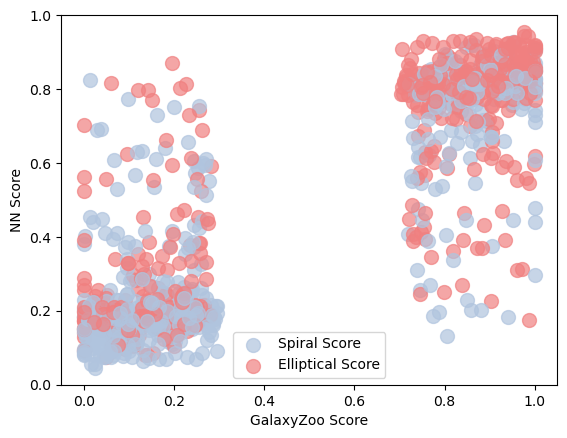

In [11]:
# compare the predicted scores and galaxy zoo scores
for i in range(len(X_test_[:500])):
    model_out = model.predict([X_test_[i]])

    plt.scatter(Y_test[i][0], model_out[0][0],color='lightsteelblue',alpha=0.7,s=100,label='Spiral Score'if i==0 else None)
    plt.scatter(Y_test[i][1], model_out[0][1],color='lightcoral',alpha=0.7,s=100,label='Elliptical Score'if i==0 else None)   
    
_ = plt.legend()

_ = plt.xlabel('GalaxyZoo Score')
_ = plt.ylabel('NN Score')

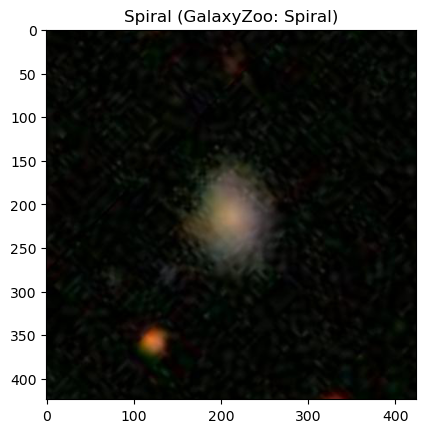

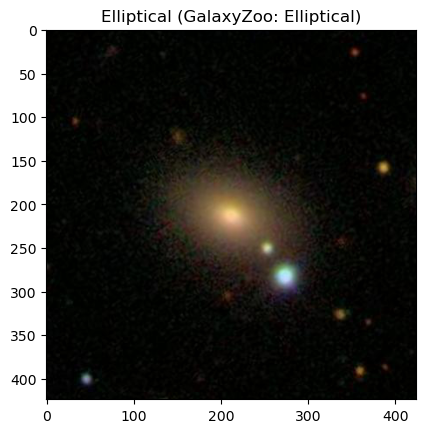

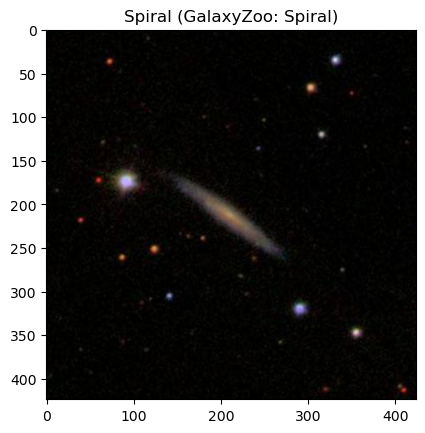

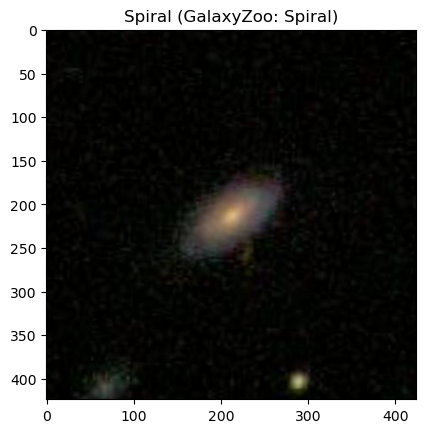

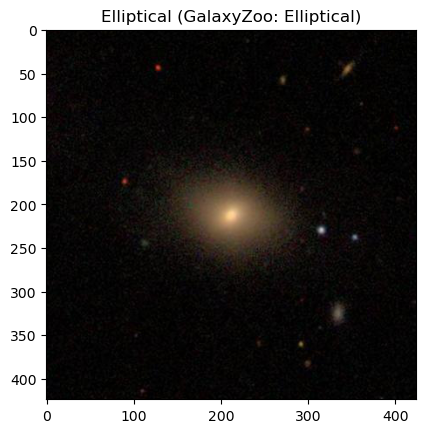

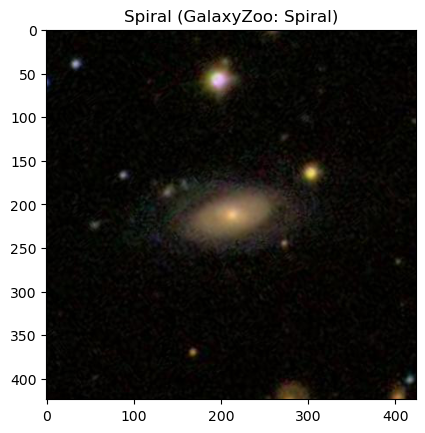

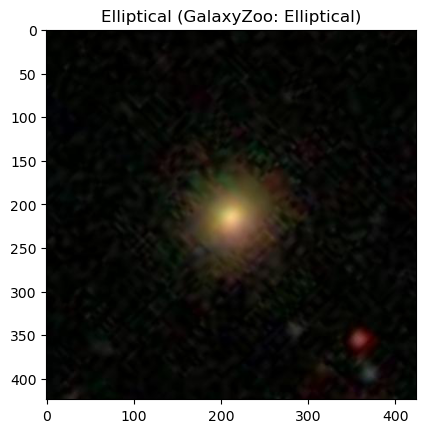

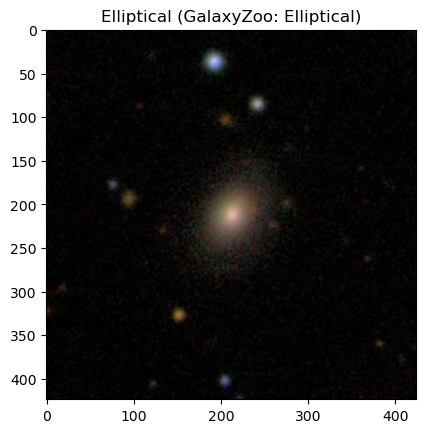

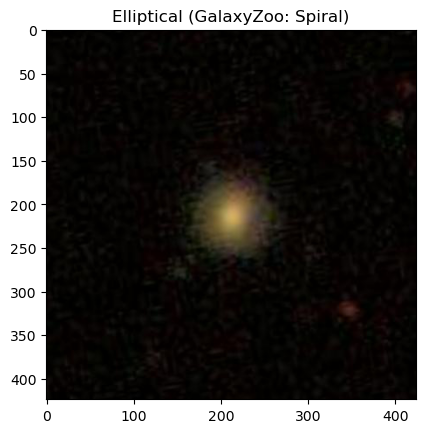

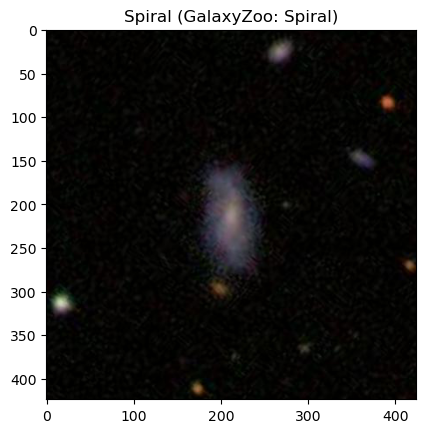

In [12]:
# predicted classification for N test galaxies
N = 10

for i in range(len(X_test_[:N])):
    model_out = model.predict([X_test_[i]])

    if model_out[0][0] < 0.5:
        title = 'Spiral'
    else:
        title = 'Elliptical'
        
    if Y_test[i][0] < 0.5:
        title += ' (GalaxyZoo: Spiral)'
    else:
        title += ' (GalaxyZoo: Elliptical)'
        
    plt.imshow(I_test[i])
    plt.title(title)
    plt.show()